In [1]:
import pandas as pd
import requests
# from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import urllib.parse
import re
import numpy as np
import seaborn as sns
import ast
from wordcloud import WordCloud, STOPWORDS
import sklearn
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
import ast

/Users/jiazhengli/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/jiazhengli/.vscode/extensions/ms-python.python-2020.8.109390/pythonFiles/pyvsc-run-isolated.py", line 26, in <module>
    runpy.run_module(module, run_name="__main__", alter_sys=True)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_parquet('/Users/jiazhengli/Desktop/project_root/clinical_trials_interventional.parquet')
print(df.shape)
df.head()

# df = pd.read_parquet('/Users/jiazhengli/Desktop/project_root/clinical_trials_interventional.parquet', engine='pyarrow', columns=None).head(10000)
# print(df.shape)
# df.head()

(399399, 156)


,hasResults,protocolSection.identificationModule.nctId,protocolSection.identificationModule.orgStudyIdInfo.id,protocolSection.identificationModule.organization.fullName,protocolSection.identificationModule.organization.class,protocolSection.identificationModule.briefTitle,protocolSection.identificationModule.officialTitle,protocolSection.statusModule.statusVerifiedDate,protocolSection.statusModule.overallStatus,protocolSection.statusModule.expandedAccessInfo.hasExpandedAccess,...,protocolSection.oversightModule.isUnapprovedDevice,protocolSection.statusModule.delayedPosting,resultsSection.moreInfoModule.pointOfContact.phoneExt,protocolSection.designModule.nPtrsToThisExpAccNctId,protocolSection.designModule.expandedAccessTypes.individual,protocolSection.oversightModule.fdaaa801Violation,annotationSection.annotationModule.violationAnnotation.violationEvents,protocolSection.designModule.expandedAccessTypes.intermediate,protocolSection.designModule.expandedAccessTypes.treatment,protocolSection.oversightModule.isPpsd
0,False,NCT05353218,2021/923,Istanbul University,OTHER,Ultrasound-Guided Intermediate Versus Deep Cer...,Efficacy of Ultrasound-Guided Intermediate Ver...,2023-04,COMPLETED,False,...,None,None,None,NaN,None,None,None,None,None,None
1,False,NCT05713162,PIC-04-17,Fundació Sant Joan de Déu,OTHER,Evaluation of the Effect of a Social Skills Pr...,Evaluation of the Effectiveness of a Social Sk...,2022-03,COMPLETED,False,...,None,None,None,NaN,None,None,None,None,None,None
2,False,NCT05143775,KY 2020-099-01,Beijing Neurosurgical Institute,OTHER,Strategic Intervention on Preserving Language ...,Strategic Intervention on Preserving Language ...,2021-12,UNKNOWN,False,...,None,None,None,NaN,None,None,None,None,None,None
3,False,NCT05988710,222204,Vanderbilt University Medical Center,OTHER,Low-dose Buccal Buprenorphine: Relative Abuse ...,Low-dose Buccal Buprenorphine: Relative Abuse ...,2024-12,RECRUITING,False,...,None,None,None,NaN,None,None,None,None,None,None
4,False,NCT01707277,EMI,Fundación para la Investigación del Hospital C...,OTHER,The Effects of Inspiratory Muscle Training in ...,The Effects of Inspiratory Muscle Training in ...,2016-02,COMPLETED,False,...,None,None,None,NaN,None,None,None,None,None,None


In [3]:
df = df[df['protocolSection.referencesModule.references'].notna() & 
        df['protocolSection.referencesModule.references'].apply(lambda x: isinstance(x, np.ndarray) and x.size > 0)]

df = df.reset_index(drop=True)

In [4]:
df.columns = [
    col if col == "hasResults" else col.split(".", 1)[-1].replace(".", "_")
    for col in df.columns
]

In [5]:
columns_to_keep = ['identificationModule_nctId', 'designModule_phases', 'identificationModule_organization_class', 'oversightModule_oversightHasDmc', 'oversightModule_isFdaRegulatedDrug', 'oversightModule_isFdaRegulatedDevice',
'designModule_designInfo_allocation', 'designModule_designInfo_interventionModel', 'eligibilityModule_minimumAge','eligibilityModule_maximumAge','designModule_designInfo_primaryPurpose', 'designModule_designInfo_maskingInfo_masking', 'eligibilityModule_healthyVolunteers', 'eligibilityModule_sex', 'moreInfoModule_certainAgreement_piSponsorEmployee',
'moreInfoModule_certainAgreement_restrictiveAgreement', 'statusModule_completionDateStruct_date', 'armsInterventionsModule_armGroups', 'designModule_enrollmentInfo_count', 'sponsorCollaboratorsModule_leadSponsor_class',
'statusModule_startDateStruct_date', 'eligibilityModule_eligibilityCriteria', 'contactsLocationsModule_locations',
'conditionBrowseModule_ancestors', 'sponsorCollaboratorsModule_collaborators', 'interventionBrowseModule_meshes',
'descriptionModule_briefSummary', 'descriptionModule_detailedDescription', 'largeDocumentModule_largeDocs', 'hasResults',
'statusModule_overallStatus'
]

df = df[columns_to_keep]
print(df.shape)
df.head()

(136928, 31)


,identificationModule_nctId,designModule_phases,identificationModule_organization_class,oversightModule_oversightHasDmc,oversightModule_isFdaRegulatedDrug,oversightModule_isFdaRegulatedDevice,designModule_designInfo_allocation,designModule_designInfo_interventionModel,eligibilityModule_minimumAge,eligibilityModule_maximumAge,...,eligibilityModule_eligibilityCriteria,contactsLocationsModule_locations,conditionBrowseModule_ancestors,sponsorCollaboratorsModule_collaborators,interventionBrowseModule_meshes,descriptionModule_briefSummary,descriptionModule_detailedDescription,largeDocumentModule_largeDocs,hasResults,statusModule_overallStatus
0,NCT05713162,[NA],OTHER,None,False,False,RANDOMIZED,PARALLEL,8 Years,17 Years,...,Inclusion Criteria:\n\n* age range between 8 a...,"[{'city': 'Barcelona', 'contacts': None, 'coun...","[{'id': 'D002659', 'term': 'Child Development ...",None,None,Research evaluating effectiveness of social sk...,Participants were recruited by psychologists a...,None,False,COMPLETED
1,NCT05143775,[NA],OTHER,True,False,False,RANDOMIZED,PARALLEL,18 Years,70 Years,...,"Inclusion Criteria:\n\n1, patients with glioma...","[{'city': 'Beijing', 'contacts': None, 'countr...","[{'id': 'D018302', 'term': 'Neoplasms, Neuroep...",None,None,This study is designed to compare the language...,This study concentrates on patient who has typ...,None,False,UNKNOWN
2,NCT01707277,[NA],OTHER,False,None,None,RANDOMIZED,PARALLEL,None,None,...,Inclusion Criteria:\n\n* a) previous history o...,"[{'city': 'Valencia', 'contacts': None, 'count...","[{'id': 'D006331', 'term': 'Heart Diseases'}, ...","[{'class': 'OTHER', 'name': 'University of Val...",None,Previous studies have evaluated the effects of...,None,None,False,COMPLETED
3,NCT02953301,[PHASE2],INDUSTRY,True,None,None,RANDOMIZED,PARALLEL,18 Years,None,...,Main Inclusion Criteria:\n\n* Patients with hi...,"[{'city': 'Graz', 'contacts': None, 'country':...","[{'id': 'D004194', 'term': 'Disease'}, {'id': ...",None,None,The purpose of this study is to determine whet...,None,None,False,COMPLETED
4,NCT05060471,[PHASE2],OTHER,True,False,False,NA,SINGLE_GROUP,18 Years,75 Years,...,Inclusion Criteria:\n\n(1) Histology confirmed...,"[{'city': 'Guangzhou', 'contacts': None, 'coun...","[{'id': 'D009375', 'term': 'Neoplasms, Glandul...",None,None,Locally Advanced Anal Canal Squamous Carcinoma...,None,None,False,COMPLETED


Encode Phase

In [6]:
# Rename values in the 'Phase' column

# def fix_phases(phases):
#     if pd.isna(phases):  # Handle NaN values
#         return ['NA']
#     if isinstance(phases, str):  # Convert string to a Python list
#         try:
#             phases = ast.literal_eval(phases)  # Safely parse the string
#         except (ValueError, SyntaxError):  # Handle any malformed strings
#             return ['NA']
#     if isinstance(phases, list):  # Process the list
#         return ['PHASE1' if phase == 'EARLY_PHASE1' else phase for phase in phases]
#     return ['NA']  # Default to ['NA'] for unexpected cases

# df['designModule_phases'] = df['designModule_phases'].apply(fix_phases)
def fix_phases(phases):
    if isinstance(phases, float) and pd.isna(phases):  # Handle NaN values
        return ['NA']

    if isinstance(phases, np.ndarray):  # Convert NumPy arrays to Python lists
        phases = phases.tolist()

    if isinstance(phases, list):  # Process lists correctly
        return ['PHASE1' if phase == 'EARLY_PHASE1' else phase for phase in phases]

    return ['NA']  # Default case

# Apply function with `.loc` to avoid `SettingWithCopyWarning`
df.loc[:, 'designModule_phases'] = df['designModule_phases']

df['designModule_phases'].value_counts()

designModule_phases
[NA]                68981
[PHASE2]            19022
[PHASE3]            17226
[PHASE4]            12983
[PHASE1]             9921
                    ...  
[PHASE1, PHASE2]        1
[PHASE1, PHASE2]        1
[PHASE2, PHASE3]        1
[PHASE1, PHASE2]        1
[PHASE1, PHASE2]        1
Name: count, Length: 7385, dtype: int64

In [7]:
# Ensure the column contains only valid lists
df['designModule_phases'] = df['designModule_phases'].apply(
    lambda x: x.tolist() if isinstance(x, np.ndarray) else x  # Convert NumPy arrays to lists
)

# Create dummy variables for each phase
valid_phases = ['PHASE1', 'PHASE2', 'PHASE3', 'PHASE4', 'NA']

for phase in valid_phases:
    df[phase] = df['designModule_phases'].apply(lambda x: int(phase in x) if isinstance(x, list) else 0)

# Display the dummy columns
print(df[valid_phases].head())

PHASE1  PHASE2  PHASE3  PHASE4  NA
0       0       0       0       0   1
1       0       0       0       0   1
2       0       0       0       0   1
3       0       1       0       0   0
4       0       1       0       0   0


In [8]:
df = df.drop(columns=['NA','designModule_phases'])

In [9]:
# def create_dummies(df, column_name):
#     """
#     Creates dummy variables for a categorical column, handles missing values, and drops the original column and 'NA' dummy.

#     Parameters:
#         df (pd.DataFrame): The DataFrame containing the column to process.
#         column_name (str): The name of the column to transform.

#     Returns:
#         pd.DataFrame: The DataFrame with dummy variables added and the original column removed.
#     """
#     # Check for missing values and fill with 'NA'
#     df[column_name] = df[column_name].fillna('NA')

#     # Create dummy variables
#     dummies = pd.get_dummies(df[column_name], prefix="", prefix_sep="")

#     # Drop the 'NA' column if it exists
#     if 'NA' in dummies.columns:
#         dummies = dummies.drop(columns=['NA'])

#     # Drop the original column
#     df = df.drop(columns=[column_name])

#     # Concatenate the dummies with the original DataFrame
#     df = pd.concat([df, dummies], axis=1)

#     return df
def create_dummies(df, column_name):
    """
    Creates dummy variables for a categorical column, handles missing values, and drops the original column and 'NA' dummy.
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    df[column_name] = df[column_name].fillna('NA')
    dummies = pd.get_dummies(df[column_name], prefix="", prefix_sep="")

    if 'NA' in dummies.columns:
        dummies = dummies.drop(columns='NA')

    df = pd.concat([df.drop(columns=column_name), dummies], axis=1)
    return df


Encode organization class

In [10]:
df = create_dummies(df, 'identificationModule_organization_class')
df = df.rename(columns={
    'FED': 'organization_class_FED',
    'INDIV': 'organization_class_INDIV',
    'INDUSTRY': 'organization_class_INDUSTRY',
    'NETWORK': 'organization_class_NETWORK',
    'NIH': 'organization_class_NIH',
    'OTHER': 'organization_class_OTHER',
    'OTHER_GOV': 'organization_class_OTHER_GOV',
    'UNKNOWN': 'organization_class_UNKNOWN'
})

In [11]:
df = create_dummies(df, 'oversightModule_oversightHasDmc')
df = df.rename(columns={
    'False': 'oversightHasDmc_no',
    'True': 'oversightHasDmc_yes'
})

In [12]:
df = create_dummies(df, 'oversightModule_isFdaRegulatedDrug')
df = df.rename(columns={
    'False': 'FdaRegulatedDrug_no',
    'True': 'FdaRegulatedDrug_yes'
})

In [13]:
df = create_dummies(df, 'oversightModule_isFdaRegulatedDevice')
df = df.rename(columns={
    'False': 'FdaRegulatedDevice_no',
    'True': 'FdaRegulatedDevice_yes'
})

In [14]:
df = create_dummies(df, 'designModule_designInfo_allocation')
df = df.rename(columns={
    'NON_RANDOMIZED': 'designInfo_allocation_NON_RANDOMIZED',
    'RANDOMIZED': 'designInfo_allocation_RANDOMIZED'
})

In [15]:
df = create_dummies(df, 'designModule_designInfo_interventionModel')
df = df.rename(columns={
    'CROSSOVER': 'interventionModel_CROSSOVER',
    'FACTORIAL': 'interventionModel_FACTORIAL',
    'PARALLEL': 'interventionModel_PARALLEL',
    'SEQUENTIAL': 'interventionModel_SEQUENTIAL',
    'SINGLE_GROUP': 'interventionModel_SINGLE_GROUP'
})

In [16]:
df = create_dummies(df, 'designModule_designInfo_primaryPurpose')
df = df.rename(columns={
    'BASIC_SCIENCE': 'primaryPurpose_BASIC_SCIENCE',
    'DEVICE_FEASIBILITY': 'primaryPurpose_DEVICE_FEASIBILITY',
    'DIAGNOSTIC': 'primaryPurpose_DIAGNOSTIC',
    'ECT': 'primaryPurpose_ECT',
    'HEALTH_SERVICES_RESEARCH': 'primaryPurpose_HEALTH_SERVICES_RESEARCH',
    'OTHER': 'primaryPurpose_OTHER',
    'PREVENTION': 'primaryPurpose_PREVENTION',
    'SCREENING': 'primaryPurpose_SCREENING',
    'SUPPORTIVE_CARE': 'primaryPurpose_SUPPORTIVE_CARE',
    'TREATMENT': 'primaryPurpose_TREATMENT'
})

In [17]:
df = create_dummies(df, 'designModule_designInfo_maskingInfo_masking')
df = df.rename(columns={
    'DOUBLE': 'masking_DOUBLE',
    'NONE': 'masking_NONE',
    'QUADRUPLE': 'masking_QUADRUPLE',
    'SINGLE': 'masking_SINGLE',
    'TRIPLE': 'masking_TRIPLE'
})

In [18]:
df = create_dummies(df, 'eligibilityModule_healthyVolunteers')
df = df.rename(columns={
    'False': 'healthyVolunteers_no',
    'True': 'healthyVolunteers_yes'
})

In [19]:
df = create_dummies(df, 'eligibilityModule_sex')
df = df.rename(columns={
    'ALL': 'sex_all',
    'FEMALE': 'sex_female',
    'MALE': 'sex_male'
})

In [20]:
df = create_dummies(df, 'moreInfoModule_certainAgreement_piSponsorEmployee')
df = df.rename(columns={
    'False': 'piSponsorEmployee_no',
    'True': 'piSponsorEmployee_yes'
})

In [21]:
df = create_dummies(df, 'moreInfoModule_certainAgreement_restrictiveAgreement')
df = df.rename(columns={
    'False': 'restrictiveAgreement_no',
    'True': 'restrictiveAgreement_yes'
})

In [22]:
df = create_dummies(df, 'hasResults')
df = df.rename(columns={
    'False': 'hasResults_no',
    'True': 'hasResults_yes'
})

In [23]:
def fill_incomplete_date(date_str):
    if pd.isna(date_str):
        return date_str  # Leave NaN as is
    if len(date_str) == 7:  # Format like '2004-10'
        return date_str + '-15'  # Add '-15' for the middle of the month
    return date_str

# Clean and fill incomplete dates
df['statusModule_startDateStruct_date'] = df['statusModule_startDateStruct_date'].apply(fill_incomplete_date)
df['statusModule_completionDateStruct_date'] = df['statusModule_completionDateStruct_date'].apply(fill_incomplete_date)

# Convert to datetime, leaving NaN values as is
df['statusModule_startDateStruct_date'] = pd.to_datetime(df['statusModule_startDateStruct_date'], errors='coerce')
df['statusModule_completionDateStruct_date'] = pd.to_datetime(df['statusModule_completionDateStruct_date'], errors='coerce')

# Calculate duration in years for non-missing dates
df['duration_of_trial'] = (
    (df['statusModule_completionDateStruct_date'] - df['statusModule_startDateStruct_date']).dt.days / 365
)

# Group by 'statusModule_overallStatus' to calculate the average duration for each status
average_durations = (
    df[df['duration_of_trial'].notna()]
    .groupby('statusModule_overallStatus')['duration_of_trial']
    .mean()
)
# Fill missing durations with the average duration based on 'statusModule_overallStatus'
def fill_missing_duration(row):
    if pd.isna(row['duration_of_trial']):
        return average_durations.get(row['statusModule_overallStatus'], None)  # Default to None if no status match
    return row['duration_of_trial']

df['duration_of_trial'] = df.apply(fill_missing_duration, axis=1)

df = df.drop(columns=['statusModule_startDateStruct_date', 'statusModule_completionDateStruct_date'])


In [24]:
df['duration_of_trial'] = df['duration_of_trial'].fillna(df['duration_of_trial'].mean())
print("Missing values in 'duration_of_trial':", df['duration_of_trial'].isna().sum())

Missing values in 'duration_of_trial': 0


In [25]:
def convert_age(value):
    if pd.isna(value):  # Handle missing values
        return None
    elif "Weeks" in value:
        return round(int(value.split()[0]) / 52, 2)  # Convert weeks to years
    elif "Years" in value:
        return int(value.split()[0])  # Extract numerical part
    return None  # If unrecognized format

# Apply conversion to both columns
df['eligibilityModule_minimumAge'] = df['eligibilityModule_minimumAge'].apply(convert_age)
df['eligibilityModule_maximumAge'] = df['eligibilityModule_maximumAge'].apply(convert_age)

# Replace missing values
df['eligibilityModule_minimumAge'].fillna(df['eligibilityModule_minimumAge'].min(), inplace=True)
df['eligibilityModule_maximumAge'].fillna(df['eligibilityModule_maximumAge'].max(), inplace=True)

/var/folders/lr/n1nc31vx3sz7dt4y6jfw_21h0000gr/T/ipykernel_92910/3706069296.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['eligibilityModule_minimumAge'].fillna(df['eligibilityModule_minimumAge'].min(), inplace=True)
/var/folders/lr/n1nc31vx3sz7dt4y6jfw_21h0000gr/T/ipykernel_92910/3706069296.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inte

In [26]:
df['eligibilityModule_maximumAge'] = df['eligibilityModule_maximumAge'].apply(lambda x: 100 if x > 100 else x)

In [27]:
print(df['eligibilityModule_minimumAge'][:10])
df['eligibilityModule_maximumAge'][:10]

0     8.00
1    18.00
2     0.00
3    18.00
4    18.00
5    18.00
6    18.00
7     0.54
8    18.00
9    45.00
Name: eligibilityModule_minimumAge, dtype: float64


0     17.00
1     70.00
2    100.00
3    100.00
4     75.00
5    100.00
6    100.00
7      0.71
8    100.00
9     58.00
Name: eligibilityModule_maximumAge, dtype: float64

In [28]:
df['designModule_enrollmentInfo_count'].fillna(df['designModule_enrollmentInfo_count'].median(), inplace=True)

/var/folders/lr/n1nc31vx3sz7dt4y6jfw_21h0000gr/T/ipykernel_92910/2601035345.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['designModule_enrollmentInfo_count'].fillna(df['designModule_enrollmentInfo_count'].median(), inplace=True)


In [29]:
def count_criteria(criteria_text):
    inclusion_count = 0
    exclusion_count = 0

    # Ensure the input is a valid string and not NaN
    if isinstance(criteria_text, str) and 'Inclusion Criteria' in criteria_text and 'Exclusion Criteria' in criteria_text:
        # Split into inclusion and exclusion sections
        try:
            inclusion_section = criteria_text.split('Inclusion Criteria:')[1].split('Exclusion Criteria:')[0]
            exclusion_section = criteria_text.split('Exclusion Criteria:')[1]

            # Count bullet points (each * represents a new criterion)
            inclusion_count = inclusion_section.count('*')
            exclusion_count = exclusion_section.count('*')
        except IndexError:
            pass  # In case there's any issue with splitting or formatting

    return inclusion_count, exclusion_count

# Apply the function to the eligibility column
df[['inclusion_count', 'exclusion_count']] = df['eligibilityModule_eligibilityCriteria'].apply(lambda x: pd.Series(count_criteria(x)))

In [30]:
df = df.drop(['eligibilityModule_eligibilityCriteria'], axis = 1)
df[['inclusion_count', 'exclusion_count']]

,inclusion_count,exclusion_count
0,4,3
1,0,0
2,4,8
3,3,3
4,0,0
...,...,...
136923,0,0
136924,5,14
136925,10,15
136926,2,5


In [31]:
def count_facilities(locations):
    if isinstance(locations, float) and pd.isna(locations):  # Handle NaN values
        return 0

    if isinstance(locations, np.ndarray):  # Convert NumPy arrays to lists
        locations = locations.tolist()

    if isinstance(locations, list):  # Directly count list items
        return len(locations)

    if isinstance(locations, str):  # Convert string representation of a list
        try:
            parsed_locations = ast.literal_eval(locations)
            if isinstance(parsed_locations, list):
                return len(parsed_locations)
        except (ValueError, SyntaxError):
            return 0  # If parsing fails, return 0

    return 0  # Default case for unexpected formats

# Apply function
df['facility_count'] = df['contactsLocationsModule_locations'].apply(count_facilities)

In [32]:
df = df.drop(['contactsLocationsModule_locations'], axis = 1)
df['facility_count']

0          1
1          1
2          1
3         54
4          1
          ..
136923     3
136924     1
136925     1
136926     1
136927     5
Name: facility_count, Length: 136928, dtype: int64

In [33]:
disease_type = [
    'Infections', 'Neoplasms', 'Musculoskeletal Diseases', 'Digestive System Diseases',
    'Stomatognathic Diseases', 'Respiratory Tract Diseases', 'Otorhinolaryngologic Diseases',
    'Nervous System Diseases', 'Eye Diseases', 'Urogenital Diseases', 'Cardiovascular Diseases',
    'Hemic and Lymphatic Diseases', 'Congenital, Hereditary, and Neonatal Diseases and Abnormalities',
    'Skin and Connective Tissue Diseases', 'Nutritional and Metabolic Diseases',
    'Endocrine System Diseases', 'Immune System Diseases', 'Disorders of Environmental Origin',
    'Animal Diseases', 'Pathological Conditions, Signs and Symptoms', 'Occupational Diseases',
    'Chemically-Induced Disorders', 'Wounds and Injuries']

disease_type_set = set(disease_type)
disease_type_lower = set(dt.lower() for dt in disease_type)

# 2. Define parsing functions
# def parse_ancestors(entry):
#     if isinstance(entry, str):
#         try:
#             return ast.literal_eval(entry)
#         except (ValueError, SyntaxError) as e:
#             print(f"Parsing error: {e} for entry: {entry[:50]}...")
#             return []
#     else:
#         return []

# def extract_disease_terms(ancestors, disease_type_set):
#     if not isinstance(ancestors, list):
#         return []
#     return [entry.get('term') for entry in ancestors if entry.get('term') in disease_type_set]

# def extract_unique_sorted_terms(ancestors, disease_type_set):
#     if not isinstance(ancestors, list):
#         return []
#     filtered_terms = {entry.get('term') for entry in ancestors if entry.get('term') in disease_type_set}
#     return sorted(filtered_terms)

# def extract_disease_terms_case_insensitive(ancestors, disease_type_lower_set):
#     if not isinstance(ancestors, list):
#         return []
#     return [entry.get('term') for entry in ancestors if entry.get('term', '').lower() in disease_type_lower_set]

# df['parsed_ancestors'] = df['conditionBrowseModule_ancestors'].apply(parse_ancestors)

# df['selected_disease_names'] = df['parsed_ancestors'].apply(lambda x: extract_unique_sorted_terms(x, disease_type_set))

# df.drop(columns=['parsed_ancestors'], inplace=True)

# print(df[['conditionBrowseModule_ancestors', 'selected_disease_names']].head())
def extract_unique_sorted_terms(ancestors, disease_type_set):
    if isinstance(ancestors, np.ndarray):  # Convert NumPy arrays to Python lists
        ancestors = ancestors.tolist()

    if not isinstance(ancestors, list):  # Ensure it's a list
        print(f"Unexpected data format: {type(ancestors)} - {ancestors}")
        return []

    filtered_terms = {entry.get('term') for entry in ancestors if isinstance(entry, dict) and entry.get('term') in disease_type_set}

    if not filtered_terms:  # Log empty results for debugging
        print(f"No matches found in: {ancestors}")

    return sorted(filtered_terms)

# Apply function
df['selected_disease_names'] = df['conditionBrowseModule_ancestors'].apply(lambda x: extract_unique_sorted_terms(x, disease_type_set))

ected data format: <class 'NoneType'> - None
No matches found in: [{'id': 'D011183', 'term': 'Postoperative Complications'}, {'id': 'D010335', 'term': 'Pathologic Processes'}, {'id': 'D010146', 'term': 'Pain'}, {'id': 'D009461', 'term': 'Neurologic Manifestations'}]
Unexpected data format: <class 'NoneType'> - None
Unexpected data format: <class 'NoneType'> - None
Unexpected data format: <class 'NoneType'> - None
Unexpected data format: <class 'NoneType'> - None
No matches found in: [{'id': 'D001791', 'term': 'Blood Platelet Disorders'}, {'id': 'D006402', 'term': 'Hematologic Diseases'}, {'id': 'D000095542', 'term': 'Cytopenia'}]
Unexpected data format: <class 'NoneType'> - None
No matches found in: [{'id': 'D009748', 'term': 'Nutrition Disorders'}]
Unexpected data format: <class 'NoneType'> - None
Unexpected data format: <class 'NoneType'> - None
Unexpected data format: <class 'NoneType'> - None
No matches found in: [{'id': 'D020969', 'term': 'Disease Attributes'}, {'id': 'D010335', '

In [34]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=disease_type)
dummies = pd.DataFrame(mlb.fit_transform(df['selected_disease_names']),
                       columns=mlb.classes_,
                       index=df.index)
dummies

,Infections,Neoplasms,Musculoskeletal Diseases,Digestive System Diseases,Stomatognathic Diseases,Respiratory Tract Diseases,Otorhinolaryngologic Diseases,Nervous System Diseases,Eye Diseases,Urogenital Diseases,...,Skin and Connective Tissue Diseases,Nutritional and Metabolic Diseases,Endocrine System Diseases,Immune System Diseases,Disorders of Environmental Origin,Animal Diseases,"Pathological Conditions, Signs and Symptoms",Occupational Diseases,Chemically-Induced Disorders,Wounds and Injuries
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
136924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136925,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136926,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df = df.drop(columns=['selected_disease_names', 'conditionBrowseModule_ancestors'])

In [36]:
df= pd.concat([df, dummies], axis=1)

In [37]:
def extract_classes(collaborators_entry):
    """
    Extracts 'class' values from the collaborators entry.

    Parameters:
    - collaborators_entry (str, list, or np.ndarray): A list of dictionaries or an array.

    Returns:
    - list: A list of 'class' values. Returns an empty list if input is invalid or missing.
    """
    if isinstance(collaborators_entry, float) and pd.isna(collaborators_entry):  # Handle NaN values
        return []

    if isinstance(collaborators_entry, np.ndarray):  # Convert NumPy arrays to lists
        collaborators_entry = collaborators_entry.tolist()

    if isinstance(collaborators_entry, list):  # Ensure it's a list
        class_list = [entry.get('class') for entry in collaborators_entry if isinstance(entry, dict) and 'class' in entry]
        return class_list if class_list else []  # Ensure output is a list

    return []  # Default case for unexpected types

# Apply function with `.loc` to avoid SettingWithCopyWarning
df.loc[:, 'collaborator_classes'] = df['sponsorCollaboratorsModule_collaborators'].apply(extract_classes)

# Check the results
print(df['collaborator_classes'].head(10))

0                                       []
1                                       []
2                                  [OTHER]
3                                       []
4                                       []
5                                  [OTHER]
6                                       []
7                                       []
8                                       []
9    [OTHER, INDUSTRY, INDUSTRY, INDUSTRY]
Name: collaborator_classes, dtype: object


In [38]:
from sklearn.preprocessing import MultiLabelBinarizer

unique_classes = set(
    class_name
    for sublist in df['collaborator_classes'].dropna()
    for class_name in sublist
)

# Optional: Sort the classes for consistency
predefined_classes = sorted(unique_classes)

print("Unique Classes:", predefined_classes)

# Step 2: Replace NaN with empty lists
df['collaborator_classes'] = df['collaborator_classes'].apply(
    lambda x: x if isinstance(x, list) else []
)

# Step 3: Initialize MultiLabelBinarizer with predefined classes
mlb = MultiLabelBinarizer(classes=predefined_classes)

# Step 4: Fit and transform the 'collaborator_classes' column
dummies = pd.DataFrame(
    mlb.fit_transform(df['collaborator_classes']),
    columns=mlb.classes_,
    index=df.index
)

rename_dict = {col: f'collaborator_{col}' for col in dummies.columns}

# Rename the columns
dummies = dummies.rename(columns=rename_dict)

dummies

Unique Classes: ['AMBIG', 'FED', 'INDIV', 'INDUSTRY', 'NETWORK', 'NIH', 'OTHER', 'OTHER_GOV', 'UNKNOWN']


,collaborator_AMBIG,collaborator_FED,collaborator_INDIV,collaborator_INDUSTRY,collaborator_NETWORK,collaborator_NIH,collaborator_OTHER,collaborator_OTHER_GOV,collaborator_UNKNOWN
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
136923,0,0,0,0,0,0,1,0,0
136924,0,0,0,0,0,1,0,0,0
136925,0,0,0,1,0,0,1,0,0
136926,0,0,0,0,0,0,0,0,0


In [39]:
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=['sponsorCollaboratorsModule_collaborators','collaborator_classes'])

In [40]:
rare_categories = ['AMBIG', 'UNKNOWN', 'INDIV']

# Replace rare categories with "OTHER_SMALL"
df['sponsorCollaboratorsModule_leadSponsor_class'] = df['sponsorCollaboratorsModule_leadSponsor_class'].replace(rare_categories, 'OTHER_SMALL')

# Create dummies while adding a prefix
df = pd.get_dummies(df, columns=['sponsorCollaboratorsModule_leadSponsor_class'], prefix='leadsponsor')

Match the intervention names into broader Mesh terms

In [41]:
def extract_d_ids(mesh_list):
    if isinstance(mesh_list, float) and pd.isna(mesh_list):  # Handle NaN values
        return []

    if isinstance(mesh_list, np.ndarray):  # Convert NumPy arrays to lists
        mesh_list = mesh_list.tolist()

    if isinstance(mesh_list, list):  # Process valid lists directly
        return [item['id'] for item in mesh_list if isinstance(item, dict) and 'id' in item and item['id'].startswith('D')]

    if isinstance(mesh_list, str):  # Convert string to a Python object
        try:
            parsed_list = ast.literal_eval(mesh_list)
            if isinstance(parsed_list, list):
                return [item['id'] for item in parsed_list if isinstance(item, dict) and 'id' in item and item['id'].startswith('D')]
        except (SyntaxError, ValueError):
            return []

    return []  # Default case for unexpected formats

# Apply function
df['interventions_mesh_ids'] = df['interventionBrowseModule_meshes'].apply(extract_d_ids)

In [45]:
import requests
import time

def fetch_tree_numbers(id_format, max_retries=3, retry_delay=5):
    """Fetch tree numbers from MeSH API with automatic retries."""
    url = f"https://id.nlm.nih.gov/mesh/{id_format}.json"
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=10)  # Set timeout
            if response.status_code == 200:
                data = response.json()
                tree_numbers = data.get('treeNumber', [])
                if isinstance(tree_numbers, str):
                    tree_numbers = [tree_numbers.split('/')[-1]]
                elif isinstance(tree_numbers, list):
                    tree_numbers = [tn.split('/')[-1] for tn in tree_numbers]
                return tree_numbers  # Successful request
            
            print(f"Request failed for {id_format}, status code {response.status_code}. Retrying... ({attempt+1}/{max_retries})")
        
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {id_format}: {e}. Retrying... ({attempt+1}/{max_retries})")
        
        time.sleep(retry_delay)  # Wait before retrying

    print(f"Final failure for {id_format}. Skipping...")
    return []  # Return empty list if all retries fail

cache = {}
def get_mesh_tree_number_cached(mesh_id):
    if mesh_id in cache:
        return cache[mesh_id]

    tree_numbers = get_mesh_tree_number(mesh_id)
    cache[mesh_id] = tree_numbers  # Store result in cache
    return tree_numbers

# Function to process each list of IDs in the column and get all tree numbers
def get_all_tree_numbers(id_list, row_index, total_rows):
    if not isinstance(id_list, list) or len(id_list) == 0:  
        return 'No tree number'  # Skip empty lists

    tree_parts = set()
    for mesh_id in id_list:
        tree_numbers = get_mesh_tree_number_cached(mesh_id)
        if tree_numbers != 'No tree number':
            tree_parts.update(tree_numbers.split(', '))

        time.sleep(0.5)  # Avoid hitting the server too fast

    if (row_index + 1) % 500 == 0:
        print(f"Processed {row_index + 1}/{total_rows} rows...")

    return ', '.join(sorted(tree_parts)) if tree_parts else 'No tree number'

# Apply function with controlled rate
total_rows = len(df)
df['tree_numbers'] = [get_all_tree_numbers(id_list, idx, total_rows) for idx, id_list in enumerate(df['interventions_mesh_ids'])]

df[['interventions_mesh_ids', 'tree_numbers']]

Processed 500/136928 rows...
Processed 1500/136928 rows...
Processed 2000/136928 rows...
Processed 4000/136928 rows...
Processed 5000/136928 rows...
Processed 7000/136928 rows...
Processed 8500/136928 rows...
Processed 9000/136928 rows...
Processed 11000/136928 rows...
Processed 13500/136928 rows...
Processed 14000/136928 rows...
Processed 15000/136928 rows...
Processed 16500/136928 rows...
Processed 17000/136928 rows...
Processed 19500/136928 rows...
Processed 21500/136928 rows...
Processed 22500/136928 rows...
Processed 23500/136928 rows...
Processed 26500/136928 rows...
Processed 27000/136928 rows...
Processed 27500/136928 rows...
Processed 29000/136928 rows...
Processed 30000/136928 rows...
Processed 30500/136928 rows...
Processed 31500/136928 rows...
Processed 32000/136928 rows...
Processed 37000/136928 rows...
Processed 38000/136928 rows...
Processed 38500/136928 rows...
Processed 39500/136928 rows...
Processed 41000/136928 rows...
Processed 43000/136928 rows...
Processed 44000/1

,interventions_mesh_ids,tree_numbers
0,[],No tree number
1,[],No tree number
2,[],No tree number
3,[],No tree number
4,[],No tree number
...,...,...
136923,[],No tree number
136924,[],No tree number
136925,[],No tree number
136926,"[D000068756, D020913]","D03, D12"


In [46]:
df1 = df

In [47]:
drugs_type = {"Inorganic Chemicals" : "D01",
              "Organic Chemicals": "D02",
              "Heterocyclic Compounds": "D03",
              "Polycyclic Compounds" : "D04",
              "Macromolecular Substances" : "D05",
              "Hormones, Hormone Substitutes, and Hormone Antagonists": "D06",
              "Enzymes and Coenzymes" : "D08",
              "Carbohydrates" : "D09",
              "Lipids" : "D10",
              "Amino Acids, Peptides, and Proteins" : "D12",
              "Nucleic Acids, Nucleotides, and Nucleosides" : "D13",
              "Complex Mixtures": "D20",
              "Biological Factors" : "D23",
              "Biomedical and Dental Materials" : "D25",
              "Pharmaceutical Preparations" : "D26",
              "Chemical Actions and Uses " : "D27"
}

code_to_drug = {v: k for k, v in drugs_type.items()}

# Function to extract relevant codes and create dummies
def extract_and_dummy(tree_numbers):
    codes = set(tree_numbers.split(", ")) if tree_numbers != "No tree number" else set()
    relevant_codes = codes.intersection(code_to_drug.keys())
    return {code_to_drug[code]: 1 for code in relevant_codes}

# Apply the function and create dummies
dummy_df = df["tree_numbers"].apply(extract_and_dummy).apply(pd.Series).fillna(0)
dummy_df.head(10)

,Organic Chemicals,"Hormones, Hormone Substitutes, and Hormone Antagonists",Chemical Actions and Uses,Lipids,Heterocyclic Compounds,"Amino Acids, Peptides, and Proteins",Polycyclic Compounds,Inorganic Chemicals,Enzymes and Coenzymes,Carbohydrates,Biological Factors,Pharmaceutical Preparations,"Nucleic Acids, Nucleotides, and Nucleosides",Complex Mixtures,Macromolecular Substances,Biomedical and Dental Materials
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df = pd.concat([df, dummy_df], axis=1)

In [49]:
num_missing = df['interventionBrowseModule_meshes'].isna().sum()
print(f"Number of missing rows: {num_missing}")
df = df.drop(columns = ['tree_numbers', 'interventions_mesh_ids','interventionBrowseModule_meshes'])

Number of missing rows: 82087


Merge trial descriptions and create embeddings

In [51]:
def combine_descriptions(row):
    detailed_desc = row['descriptionModule_detailedDescription']
    brief_summary = row['descriptionModule_briefSummary']

    # Normalize whitespace in detailed_desc and split into words
    if pd.notnull(detailed_desc):
        normalized_desc = " ".join(detailed_desc.split())  # Removes extra spaces, newlines, and tabs
        word_count = len(normalized_desc.split())

        if word_count > 8:
            return f"{brief_summary} {normalized_desc}"  # Combine the two

    return brief_summary  # Return only the brief summary

# Create the new column with combined content
df['combined_description'] = df.apply(combine_descriptions, axis=1)

print("example combined description:", df['combined_description'][40])

example combined description: Low back pain is a very common problem and the most common cause of job-related disability. While some occurrences of low back pain disappear within a couple of days, other occurrences take much longer to resolve or lead to more serious conditions. The purpose of this study is to determine the effectiveness of two behavioral types of therapy in reducing future disability in people who are receiving physical therapy for low back pain and tend to fear and avoid pain. Psychosocial factors, such as fear and avoidance, appear to play a role in the development of long-term disability from low back pain. The Fear-Avoidance Model of Exaggerated Pain Perception (FAMEPP) is a biopsychosocial model that attempts to explain how and why some individuals develop a more substantial psychological component to their low back pain problem than do others. FAMEPP suggests that an individual's pain-related fear and avoidance are the most important factors in determining whethe

In [52]:
df = df.drop(columns = ['descriptionModule_detailedDescription', 'descriptionModule_briefSummary'])
average_word_count = df['combined_description'].apply(lambda x: len(str(x).split())).mean()
average_word_count

np.float64(361.5643257770507)

In [53]:
df.to_parquet('/Users/jiazhengli/Desktop/project_root/success_model.parquet', engine='pyarrow', compression='snappy')

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm  # For progress tracking

# Load PubMedBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
model = AutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Prepare to store embeddings as a PyTorch tensor
all_embeddings = []

# Process descriptions in batches
batch_size = 16  # Increase if you have sufficient GPU memory
num_batches = (len(df) + batch_size - 1) // batch_size  # Calculate number of batches

for i in tqdm(range(num_batches)):
    # Get the current batch of descriptions
    batch_descriptions = df['combined_description'][i * batch_size : (i + 1) * batch_size].tolist()

    # Tokenize and move tokens to GPU
    tokens = tokenizer(batch_descriptions, return_tensors='pt', truncation=True, max_length=256, padding='max_length')
    tokens = {key: val.to(device) for key, val in tokens.items()}

    # Get embeddings
    with torch.no_grad():
        outputs = model(**tokens)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, sequence_length, hidden_size)
        cls_embeddings = last_hidden_state[:, 0, :]  # Extract CLS token (batch_size, 768)
        all_embeddings.append(cls_embeddings)

# Concatenate all batches into a single tensor and convert to NumPy
all_embeddings_flat = torch.cat(all_embeddings).cpu().numpy()  # Shape: (num_samples, 768)

# Ensure it matches the length of df
assert len(all_embeddings_flat) == len(df)

# Add the embeddings back to the DataFrame
df['cls_embedding'] = list(all_embeddings_flat)

100%|██████████| 250/250 [00:51<00:00,  4.85it/s]


Apply PCA dimension reduction

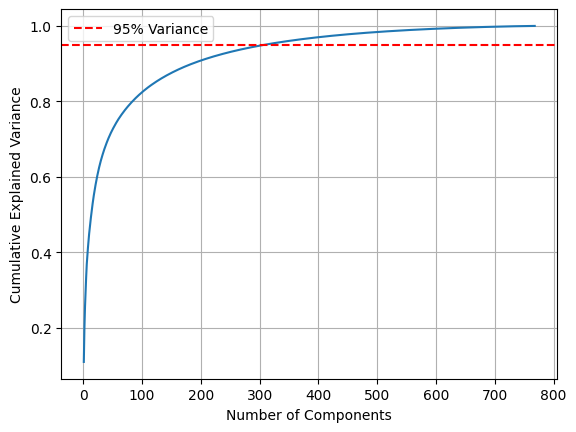

Optimal number of components: 309


In [9]:
from sklearn.decomposition import PCA

embeddings_matrix = np.vstack(df['cls_embedding'].values)

pca = PCA()
pca.fit(embeddings_matrix)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of components: {optimal_components}")

In [10]:
pca = PCA(n_components = optimal_components)
reduced_embeddings = pca.fit_transform(embeddings_matrix)

df['reduced_embedding'] = list(reduced_embeddings)

In [59]:
print(df.loc[df['identificationModule_nctId'] == 'NCT03003325', 'combined_description'].values[0])

The Low-PV study is a multicenter, phase II, randomized trial aimed to assess whether the addition of Pegylated Proline-interferon-alpha-2b to the best therapeutic current strategy available based on phlebotomies and low dose acetylsalicylic acid (ASA) could improve the efficacy of treatment of patients with PV at low risk of thrombosis (younger than 60 years and without prior vascular events), in term of control of recommended level of hematocrit \< 45%, over a period of 12 months. It is an independent, investigator-generated, pragmatic trial including adult PV patients (aged 18-60) diagnosed according to World Health Organization 2008 criteria within the last 3 years before inclusion, without history of thrombosis and younger than 60 years ('low risk' patients). Eligible patients are randomized to be treated with the best available therapy (recommended for this risk class, standard arm) based on phlebotomy including administration of low-dose (100 mg/daily) of acetylsalicylic acid (A